In [1]:
#libraries
%matplotlib inline

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import difflib as dl
import seaborn as sns
import matplotlib

## Task overview
In this task, we get university rankings from two websites, namely www.topuniversities.com and www.timeshighereducation.com . We then come up with new features from the available ones, such as the ratio of faculy to students and the ratio of international students. We find the best universities in terms of these new features. We also aggregate the data by country and region and find the best country and region for every feature.
We then display the results in bar charts.
We later merge the two datasets, perform an exploratory analysis to find correlations between the variables of the merged dataset.
Finally, we rerank the universities taking into consideration both rankings, and we find the best university accordding to this new ranking.

##  1- Top Universities data 
In this part, we get the top 200 universities from Top Universities ranking. We extract the following features for each university:
- Name
- Rank
- Country
- Region
- Total faculty
- International faculty
- Total students
- International students

As a first step, we extract the main features from the main ranking page. The main features are the Name, Country, and Region. We also extract the url relevant to each country's details page to later extract the other features.
The link to the json file we request in the get request was found using the Interceptor extension of Postman.

In [2]:
topuniversities_link = "https://www.topuniversities.com"
#get request
response_main = requests.get(topuniversities_link +"/sites/default/files/qs-rankings-data/357051.txt")
response_main_json = response_main.json()
#build dataframe from json from get request and take relevant features
main_features = pd.DataFrame.from_dict(response_main_json["data"]).head(200)[["country", "rank_display", "region", "title", "url"]]
#remove equal signs from rank
main_features["rank_display"] = pd.to_numeric(main_features["rank_display"].map(lambda x: "".join(x.split("="))))
main_features.head(10)

,country,rank_display,region,title,url
0,United States,1,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,United States,2,North America,Stanford University,/universities/stanford-university
2,United States,3,North America,Harvard University,/universities/harvard-university
3,United States,4,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,United Kingdom,5,Europe,University of Cambridge,/universities/university-cambridge
5,United Kingdom,6,Europe,University of Oxford,/universities/university-oxford
6,United Kingdom,7,Europe,UCL (University College London),/universities/ucl-university-college-london
7,United Kingdom,8,Europe,Imperial College London,/universities/imperial-college-london
8,United States,9,North America,University of Chicago,/universities/university-chicago
9,Switzerland,10,Europe,ETH Zurich - Swiss Federal Institute of Techno...,/universities/eth-zurich-swiss-federal-institu...


We use the url from the main features dataframe to get the additional information we need from the details page of each university. We send a get request to each of the pages, and parse the content using BeautifulSoup.

In [3]:
#vectors to concatenate to main_features dataframe
total_faculty_col=[]
international_faculty_col=[]
total_students_col=[]
international_students_col=[]

#use the url of each university to fetch additional information
for index, row in main_features.iterrows():
    #constructurl specific to each university
    university_url=topuniversities_link + row["url"]
    #get request to university page
    response_details=requests.get(university_url)
    response_details_html= response_details.text
    soup = BeautifulSoup(response_details_html, "html.parser")
    
    #get total number of faculty
    total_faculty=soup.find("div", class_="total faculty")
    if(total_faculty != None):
        total_faculty=int(str(total_faculty).split('<div class="number">')[1].split(" </div>")[0].strip().replace(",", ""))
    else:
        total_faculty=float("NaN")
    total_faculty_col.append(total_faculty)
    #get number of international faculty
    international_faculty=soup.find("div", class_="inter faculty")
    if (international_faculty !=None):
        international_faculty=int(str(international_faculty).split('<div class="number">')[1].split(" </div>")[0].strip().replace(",", ""))
    else:
        international_faculty=float("NaN")
    international_faculty_col.append(international_faculty)
    
    #get total number of students
    total_students=soup.find("div", class_="total student")
    if (total_students!=None):
        total_students=int(str(total_students).split('<div class="number">')[1].split(" </div>")[0].strip().replace(",", ""))
    else:
        total_students=float("NaN")
    total_students_col.append(total_students)
    
    #get number of international students
    international_students=soup.find("div", class_="total inter")
    if (international_students!=None):
        international_students=int(str(international_students).split('<div class="number">')[1].split(" </div>")[0].strip().replace(",", ""))
    else:
        international_students=float("NaN")
    international_students_col.append(international_students)

#reorder main_features dataframe and removing url column (not needed)
main_features=main_features[["title", "rank_display", "country", "region"]]
#concatenate column created from additional information page
topuniversities_df=pd.concat([main_features, pd.Series(total_faculty_col), 
                              pd.Series(international_faculty_col), pd.Series(total_students_col), 
                              pd.Series(international_students_col)], axis=1)
#rename column of topuniversities_df
topuniversities_df.columns=["Name", "Rank", "Country","Region", "Total faculty", "International faculty",  "Total students", "International students"]

topuniversities_df

,Name,Rank,Country,Region,Total faculty,International faculty,Total students,International students
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982.0,1679.0,11067.0,3717.0
1,Stanford University,2,United States,North America,4285.0,2042.0,15878.0,3611.0
2,Harvard University,3,United States,North America,4350.0,1311.0,22429.0,5266.0
3,California Institute of Technology (Caltech),4,United States,North America,953.0,350.0,2255.0,647.0
4,University of Cambridge,5,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0
5,University of Oxford,6,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0
6,UCL (University College London),7,United Kingdom,Europe,6345.0,2554.0,31080.0,14854.0
7,Imperial College London,8,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0
8,University of Chicago,9,United States,North America,2449.0,635.0,13557.0,3379.0
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,2477.0,1886.0,19815.0,7563.0


### Ratio calculation

We calculate the ratio of faculty to students and the ratio of international students for the universities, and add these new features to the dataframe

In [4]:
#add column to dataframe showing the faculty to student ratio
topuniversities_df["Faculty to students ratio"]=topuniversities_df["Total faculty"]/topuniversities_df["Total students"]

#add column to dataframe showing the ratio of international students
topuniversities_df["Ratio of international students"]=topuniversities_df["International students"]/topuniversities_df["Total students"]

### Best university in terms of ratio of faculty to students

In [5]:
#rank the universities by ratio of faculty to students and take top entry
topuniversities_df_ranked_by_fac_to_stud_ratio=topuniversities_df.sort_values("Faculty to students ratio", 
                                                                              ascending=False)
best_ratio_faculty_students = topuniversities_df_ranked_by_fac_to_stud_ratio[["Name",
                                                                              "Faculty to students ratio"]].head(1)
best_ratio_faculty_students


,Name,Faculty to students ratio
3,California Institute of Technology (Caltech),0.422616


### Best university in terms of ratio of international students

In [6]:
#rank the universities by ratio of international students and take top entry
topuniversities_df_ranked_by_inter_stud_ratio=topuniversities_df.sort_values("Ratio of international students", 
                                                                             ascending=False)
best_ratio_international_students=topuniversities_df_ranked_by_inter_stud_ratio[["Name", 
                                                                                 "Ratio of international students"]].head(1)
best_ratio_international_students


,Name,Ratio of international students
34,London School of Economics and Political Scien...,0.691393


In order to get the best country and region in terms of the ratio of faculy to students and the ratio of international students, we first group the dataframe by country and by region.
We use the grouped dataframes to get the average ratios, and then sort by the average and take the first entry.

In [7]:
#group topuniversities dataframe by country and by region
topuniversities_df_bycountry = topuniversities_df.groupby("Country")
topuniversities_df_byregion=topuniversities_df.groupby("Region")

### Best country in terms of ratio of faculty to students

In [8]:
avg_ratio_fac_to_stud_by_country = topuniversities_df_bycountry.agg({"Faculty to students ratio": np.mean})
avg_ratio_fac_to_stud_by_country_ranking=avg_ratio_fac_to_stud_by_country.sort_values("Faculty to students ratio", 
                                                                                      ascending=False)
best_country_fac_to_stud_ratio=avg_ratio_fac_to_stud_by_country_ranking.head(1)
best_country_fac_to_stud_ratio

,Faculty to students ratio
Country,
Russia,0.22191


### Best country in terms of ratio of international students

In [9]:
avg_ratio_inter_stud_by_country = topuniversities_df_bycountry.agg({"Ratio of international students": np.mean})
avg_ratio_inter_stud_by_country_ranking=avg_ratio_inter_stud_by_country.sort_values("Ratio of international students", ascending=False)
best_country_inter_stud_ratio=avg_ratio_inter_stud_by_country_ranking.head(1)
best_country_inter_stud_ratio

,Ratio of international students
Country,
United Kingdom,0.351308


### Best region in terms of ratio of faculty to students

In [10]:
avg_ratio_fac_to_stud_by_region = topuniversities_df_byregion.agg({"Faculty to students ratio": np.mean})
avg_ratio_fac_to_stud_by_region_ranking=avg_ratio_fac_to_stud_by_region.sort_values("Faculty to students ratio", ascending=False)
best_region_fac_to_stud_ratio=avg_ratio_fac_to_stud_by_region_ranking.head(1)
best_region_fac_to_stud_ratio

,Faculty to students ratio
Region,
North America,0.144831


### Best region in terms of ratio of international students

In [11]:
avg_ratio_inter_stud_by_region = topuniversities_df_byregion.agg({"Ratio of international students": np.mean})
avg_ratio_inter_stud_by_region_ranking=avg_ratio_inter_stud_by_region.sort_values("Ratio of international students", ascending=False)
best_region_inter_stud_ratio=avg_ratio_inter_stud_by_region_ranking.head(1)
best_region_inter_stud_ratio

,Ratio of international students
Region,
Oceania,0.329077


### Plots for Top Universities ranking
We create bar charts to show our data. 
We focus our attention on the ratio of faculty to students and ratio of international students.
We select only the top 10 universities, the bar charts become more readable this way.
We plot these ratios for the top 10 universities in terms of ratio of faculty to students and in terms of ratio of international students.
We also plot these ratios the top 10 countries in terms of ratio of faculty to students and in terms of ratio of international students.
We finally plot these ratios for all regions as there are only 6 regions.


### Top 10 universities in terms of faculty to students ratio

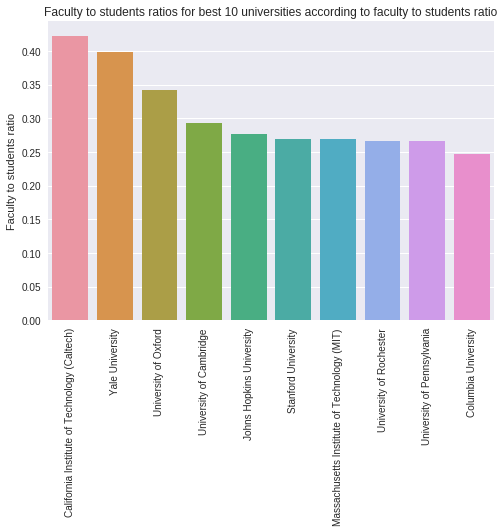

In [12]:
top_10 = topuniversities_df_ranked_by_fac_to_stud_ratio[["Name", "Faculty to students ratio"]].head(10)
matplotlib.pyplot.xticks(rotation=90)
plot_10=sns.barplot(x="Name" , y="Faculty to students ratio", data=top_10)
plot_10.set_title("Faculty to students ratios for best 10 universities according to faculty to students ratio")
plot_10=plot_10.set(xlabel='', ylabel='Faculty to students ratio')
plot_10;

Caltech university has the best faculty to student ratio.

### Top 10 universities in terms of ratio of international students

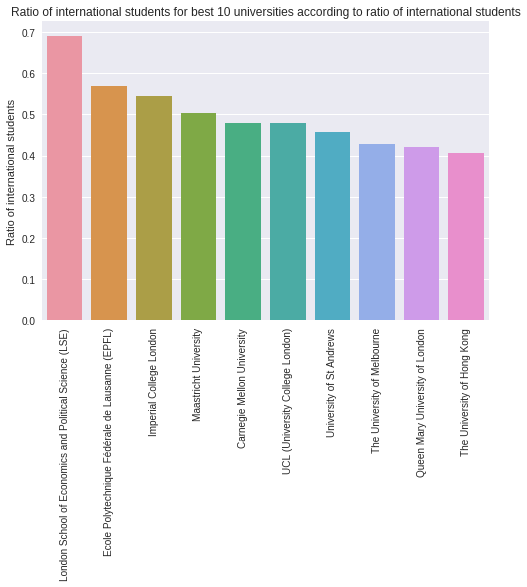

In [13]:
top_10 = topuniversities_df_ranked_by_inter_stud_ratio[["Name", "Ratio of international students"]].head(10)
matplotlib.pyplot.xticks(rotation=90)
plot_10=sns.barplot(x="Name" , y="Ratio of international students", data=top_10)
plot_10.set_title("Ratio of international students for best 10 universities according to ratio of international students")
plot_10=plot_10.set(xlabel='', ylabel="Ratio of international students")
plot_10;

LSE university has the best ratio of international students.

### Top 10 countries in terms of faculty to students ratio

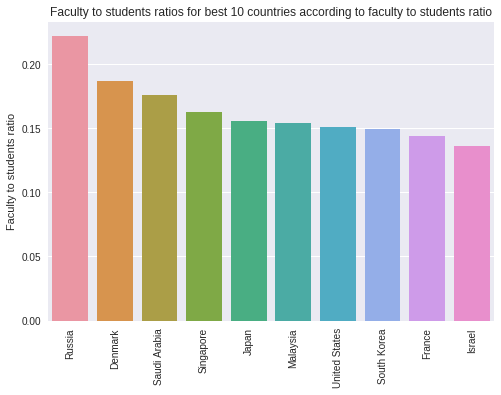

In [14]:
top_10 = avg_ratio_fac_to_stud_by_country_ranking.head(10)
matplotlib.pyplot.xticks(rotation=90)
plot_10=sns.barplot(x=top_10.index, y="Faculty to students ratio", data=top_10)
plot_10.set_title("Faculty to students ratios for best 10 countries according to faculty to students ratio")
plot_10=plot_10.set(xlabel='', ylabel='Faculty to students ratio')
plot_10;

Russia has the best average faculty to students ratio.

### Top 10 countries in terms of international students ratio

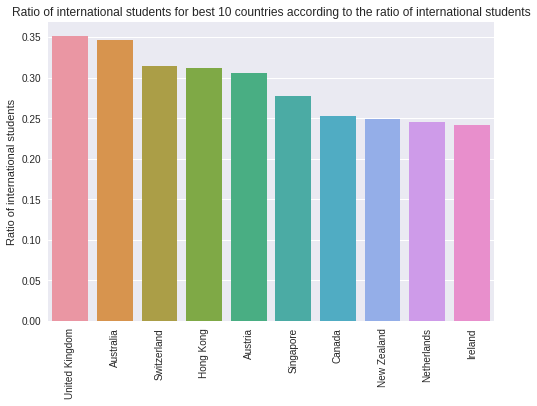

In [15]:
top_10 = avg_ratio_inter_stud_by_country_ranking.head(10)
matplotlib.pyplot.xticks(rotation=90)
plot_10=sns.barplot(x=top_10.index, y="Ratio of international students", data=top_10)
plot_10.set_title("Ratio of international students for best 10 countries according to the ratio of international students")
plot_10=plot_10.set(xlabel='', ylabel='Ratio of international students')
plot_10;

The UK has the best average international students ratio.

### Plot ratio of faculty to students for all regions

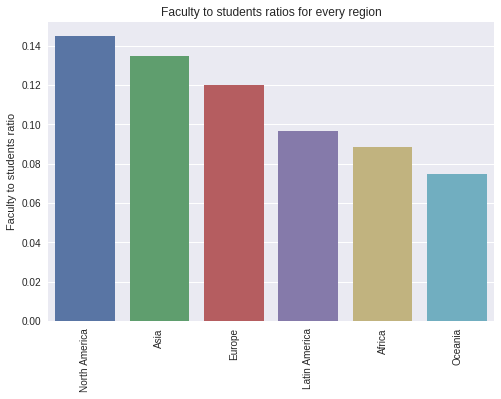

In [16]:
region_data= avg_ratio_fac_to_stud_by_region_ranking
matplotlib.pyplot.xticks(rotation=90)
plot_region=sns.barplot(x=region_data.index, y="Faculty to students ratio", data=region_data)
plot_region.set_title("Faculty to students ratios for every region")
plot_region=plot_region.set(xlabel='', ylabel='Faculty to students ratio')
plot_region;

North America has the best average faculty to students ratio.

### Plot ratio of international students for all regions

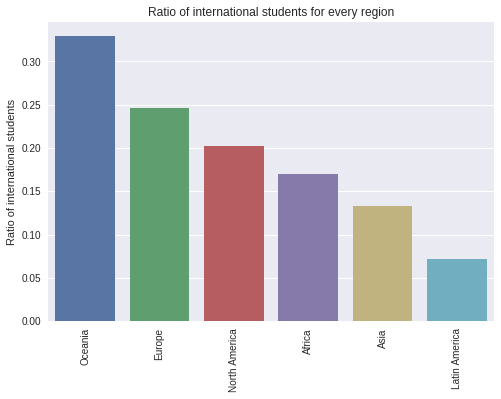

In [17]:
region_data = avg_ratio_inter_stud_by_region_ranking
matplotlib.pyplot.xticks(rotation=90)
region_plot=sns.barplot(x=region_data.index, y="Ratio of international students", data=region_data)
region_plot.set_title("Ratio of international students for every region")
region_plot=region_plot.set(xlabel='', ylabel='Ratio of international students')
region_plot;

Oceania has the best average ratio of international students.

Let us now interpret the results.

We first start with the faculty to students ratio. We can clearly see some small discrepencies in the data and in our plots. In fact, almost all the top 10 universities according to this ratio are from the USA, however in the country ranking, the USA comes in the 7'th position, while the first 3 positions are taken by countries that do not show up even once in the top 10 universities ranking (Russia, Denmark, KSA). This might be due to the fact that the USA must have a lot of universities ranked in the top 200, with a lot of them having low values of this ratio, and thus explaining why on average the USA has a lower country rank, according to the faculty to students ratio. However, the region ranking makes sense, placing North America in the first place, as expected from the available data on hand.

We now move on to the international students ratio. We clearly see the dominance of England (London in particular) in the top 10 universities according to this ratio, and the ranking per country confirms this observation, placing the UK in the first position. The ranking by region also makes sense, with Europe coming in second place (after Oceania), given that 7 out of the top 10 universities according to this ranking are located in Europe.

## 2- Times Higher Education data
In this part, we get the top 200 universities from the Times Higher Education ranking. 
The goal is to get the same information as in part 1.
In this case, all the information we need is found on the main ranking page, so we do not look at every univerity's details page.
The features available on the webpage are:
- Name
- Rank
- Country
- Number of students
- Percentage of international students
- Student to staff ratio (number of students for 1 staff member)

We consider "staff" to mean "faculty".
From these features, we extract:
- Number of international students: (percentage of international students) * (number of students)
- Total number of faculty: number of students / student to staff ratio
- Faculty to staff ratio: 1/ student to staff ratio

To get the region, we use the Top Universities dataframe to map the countries to the regions.


In [18]:
timeshighereducation_link = "https://www.timeshighereducation.com"
#get request
response_main = requests.get(timeshighereducation_link  +"/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json")
response_main_json = response_main.json()

main_features = pd.DataFrame.from_dict(response_main_json["data"]).head(200)[["aliases", "rank","location","stats_number_students", "stats_pc_intl_students", "stats_student_staff_ratio"]]
#transform percentage of international students (stats_pc_intl_students) into a number
main_features["stats_pc_intl_students"] = pd.to_numeric(main_features["stats_pc_intl_students"]
                                                        .str.split("%").str.get(0))/100
#transform student to staff ratio into staff to student ratio(stats_student_staff_ratio) into staff/student ratio
main_features["stats_staff_student_ratio"]=1/pd.to_numeric(main_features["stats_student_staff_ratio"])

#transform number of students feature into floats
main_features["stats_number_students"] = pd.to_numeric(main_features["stats_number_students"].map(lambda x: "".join(x.split(","))))
#remove equal signs from rank
main_features["rank"] = pd.to_numeric(main_features["rank"].map(lambda x: "".join(x.split("="))))

#create dataframe with needed columns for timeshighereducation
timeshighereducation_df=main_features[["aliases", "rank","location","stats_number_students", "stats_pc_intl_students", "stats_staff_student_ratio"]]
timeshighereducation_df.columns=["Name", "Rank", "Country", "Number of students", "Ratio of international students", "Faculty to students ratio"]


#map countries to region using topunivversities dataframe
regions=[]
flagged_rows=[]
for index, row in timeshighereducation_df.iterrows():
    #check if country exists in topuniversities_df
    if(len(topuniversities_df.loc[topuniversities_df["Country"] == row["Country"]]["Region"].values) !=0):
        regions.append((topuniversities_df.loc[topuniversities_df["Country"] == row["Country"]]["Region"]).values[0])
    #if not present, flag to fix manually
    else:
        regions.append("NaN") #temporary NaN just to keep track of the index in regions array
        flagged_rows.append(index)

#flaged rows for Luxembourg and Russian Federation -> both in Europe
regions[flagged_rows[0]]="Europe"
regions[flagged_rows[1]]="Europe"
#change Russian Federation to Russia for consistency
timeshighereducation_df.set_value(flagged_rows[1],"Country","Russia")
timeshighereducation_df["Region"]=pd.Series(regions)
timeshighereducation_df


,Name,Rank,Country,Number of students,Ratio of international students,Faculty to students ratio,Region
0,University of Oxford,1,United Kingdom,20409,0.38,0.089286,Europe
1,University of Cambridge,2,United Kingdom,18389,0.35,0.091743,Europe
2,California Institute of Technology caltech,3,United States,2209,0.27,0.153846,North America
3,Stanford University,3,United States,15845,0.22,0.133333,North America
4,Massachusetts Institute of Technology,5,United States,11177,0.34,0.114943,North America
5,Harvard University,6,United States,20326,0.26,0.112360,North America
6,Princeton University,7,United States,7955,0.24,0.120482,North America
7,Imperial College London,8,United Kingdom,15857,0.55,0.087719,Europe
8,University of Chicago,9,United States,13525,0.25,0.161290,North America
9,ETH Zurich – Swiss Federal Institute of Techno...,10,Switzerland,19233,0.38,0.068493,Europe


### Best university in terms of ratio of faculty to students

In [19]:
timeshighereducation_df_ranked_by_fac_to_stud_ratio=timeshighereducation_df.sort_values("Faculty to students ratio", 
                                                                                        ascending=False)
best_ratio_faculty_students = timeshighereducation_df_ranked_by_fac_to_stud_ratio[["Name", 
                                                                                   "Faculty to students ratio"]].head(1)
best_ratio_faculty_students


,Name,Faculty to students ratio
105,Vanderbilt University,0.30303


### Best university in terms of ratio of international students

In [20]:
timeshighereducation_df_ranked_by_inter_stud_ratio=timeshighereducation_df.sort_values("Ratio of international students", 
                                                                                       ascending=False)
best_ratio_international_students=timeshighereducation_df_ranked_by_inter_stud_ratio[["Name", 
                                                                                      "Ratio of international students"]].head(1)
best_ratio_international_students


,Name,Ratio of international students
24,London School of Economics and Political Science,0.71


In order to get the best country and region in terms of these ratios, we group by country and region, get the average ratio and sort on it, and take the top entry.

In [21]:
#group data by country and by region
timeshighereducation_df_bycountry = timeshighereducation_df.groupby("Country")
timeshighereducation_df_byregion=timeshighereducation_df.groupby("Region")


### Best country in terms of ratio of faculty to students

In [22]:
avg_ratio_fac_to_stud_by_country = timeshighereducation_df_bycountry.agg({"Faculty to students ratio": np.mean})
avg_ratio_fac_to_stud_by_country_ranking=avg_ratio_fac_to_stud_by_country.sort_values("Faculty to students ratio", ascending=False)
best_country_fac_to_stud_ratio=avg_ratio_fac_to_stud_by_country_ranking.head(1)
best_country_fac_to_stud_ratio


,Faculty to students ratio
Country,
Denmark,0.160166


### Best country in terms of ratio of international students

In [23]:
avg_ratio_inter_stud_by_country = timeshighereducation_df_bycountry.agg({"Ratio of international students": np.mean})
avg_ratio_inter_stud_by_country_ranking=avg_ratio_inter_stud_by_country.sort_values("Ratio of international students", ascending=False)
best_country_inter_stud_ratio=avg_ratio_inter_stud_by_country_ranking.head(1)
best_country_inter_stud_ratio


,Ratio of international students
Country,
Luxembourg,0.57


### Best region in terms of ratio of faculty to students

In [24]:
avg_ratio_fac_to_stud_by_region = timeshighereducation_df_byregion.agg({"Faculty to students ratio": np.mean})
avg_ratio_fac_to_stud_by_region_ranking=avg_ratio_fac_to_stud_by_region.sort_values("Faculty to students ratio", ascending=False)
best_region_fac_to_stud_ratio=avg_ratio_fac_to_stud_by_region_ranking.head(1)
best_region_fac_to_stud_ratio

,Faculty to students ratio
Region,
North America,0.101655


### Best region in terms of ratio of international students 

In [25]:
avg_ratio_inter_stud_by_region = timeshighereducation_df_byregion.agg({"Ratio of international students": np.mean})
avg_ratio_inter_stud_by_region_ranking=avg_ratio_inter_stud_by_region.sort_values("Ratio of international students", ascending=False)
best_region_inter_stud_ratio=avg_ratio_inter_stud_by_region_ranking.head(1)
best_region_inter_stud_ratio

,Ratio of international students
Region,
Oceania,0.305556


## Plots for Times Higher Education ranking

We plot the data as we did for Top Universities ranking.

### Top 10 universities in terms of faculty to students ratio

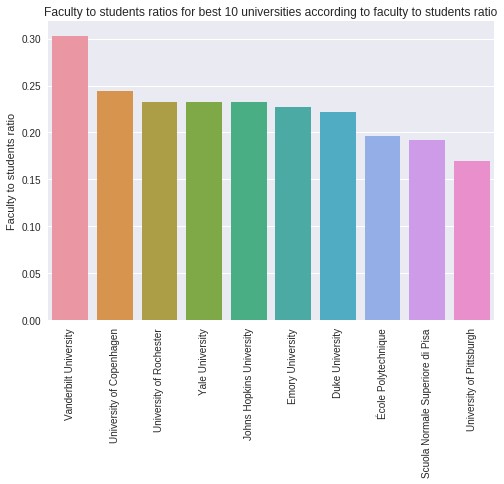

In [26]:
top_10 = timeshighereducation_df_ranked_by_fac_to_stud_ratio[["Name", "Faculty to students ratio"]].head(10)
matplotlib.pyplot.xticks(rotation=90)
plot_10=sns.barplot(x="Name" , y="Faculty to students ratio", data=top_10)
plot_10.set_title("Faculty to students ratios for best 10 universities according to faculty to students ratio")
plot_10=plot_10.set(xlabel='', ylabel='Faculty to students ratio')
plot_10;

Vanderbilt University has the best faculty to students ratio.

### Top 10 universities in terms of international students ratio

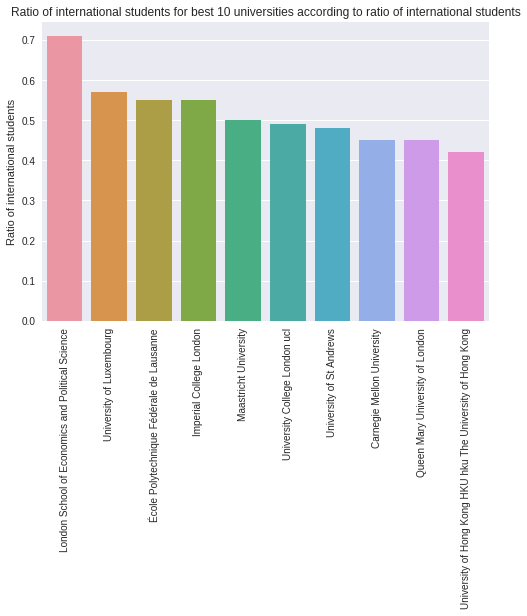

In [27]:
top_10 = timeshighereducation_df_ranked_by_inter_stud_ratio[["Name", "Ratio of international students"]].head(10)
matplotlib.pyplot.xticks(rotation=90)
plot_10=sns.barplot(x="Name" , y="Ratio of international students", data=top_10)
plot_10.set_title("Ratio of international students for best 10 universities according to ratio of international students")
plot_10=plot_10.set(xlabel='', ylabel="Ratio of international students")
plot_10;

LSE has the best ratio of international students.

### Top 10 countries in terms of faculty to students ratio

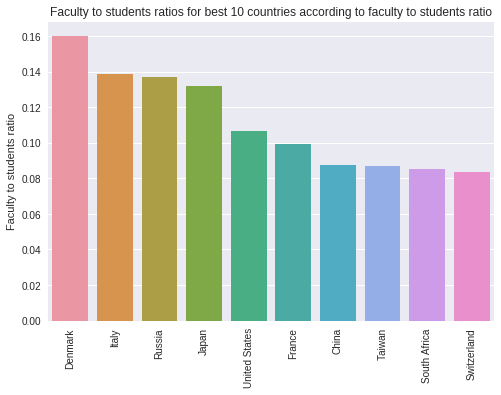

In [28]:
top_10 = avg_ratio_fac_to_stud_by_country_ranking.head(10)
matplotlib.pyplot.xticks(rotation=90)
plot_10=sns.barplot(x=top_10.index, y="Faculty to students ratio", data=top_10)
plot_10.set_title("Faculty to students ratios for best 10 countries according to faculty to students ratio")
plot_10=plot_10.set(xlabel='', ylabel='Faculty to students ratio')
plot_10;

Denmark has the best average ratio of faculty to students.

### Top 10 countries in terms of international students ratio

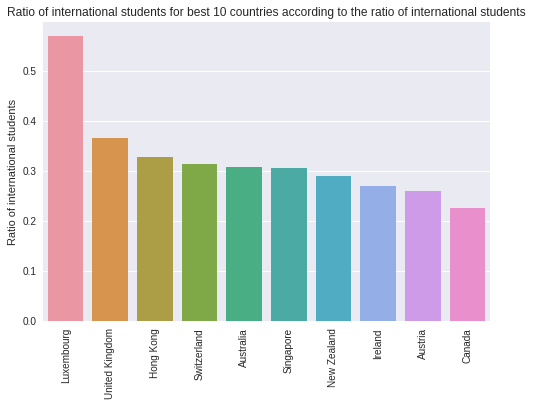

In [29]:
top_10 = avg_ratio_inter_stud_by_country_ranking.head(10)
matplotlib.pyplot.xticks(rotation=90)
plot_10=sns.barplot(x=top_10.index, y="Ratio of international students", data=top_10)
plot_10.set_title("Ratio of international students for best 10 countries according to the ratio of international students")
plot_10=plot_10.set(xlabel='', ylabel='Ratio of international students')
plot_10;

Luxembourg has the best average ratio of international students.

### Plot ratio of faculty to students for all regions

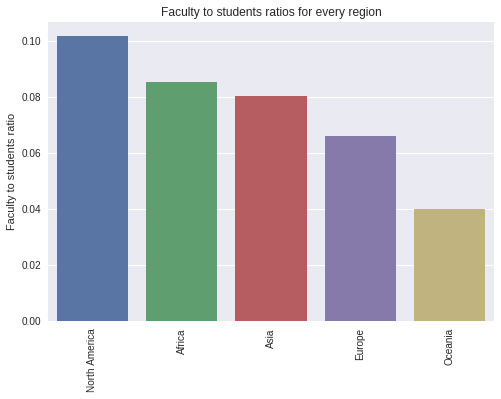

In [30]:
region_data= avg_ratio_fac_to_stud_by_region_ranking
matplotlib.pyplot.xticks(rotation=90)
plot_region=sns.barplot(x=region_data.index, y="Faculty to students ratio", data=region_data)
plot_region.set_title("Faculty to students ratios for every region")
plot_region=plot_region.set(xlabel='', ylabel='Faculty to students ratio')
plot_region;

North America has the best average ratio of faculty to students.

### Plot ratio of international students for all regions

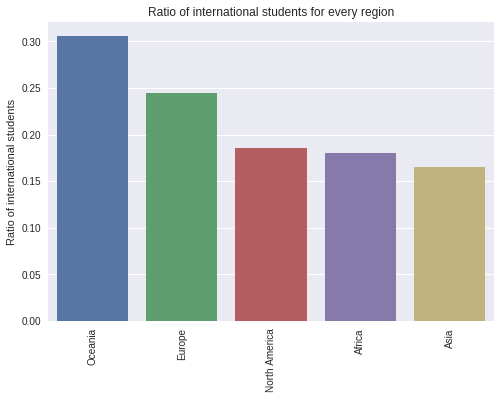

In [31]:
region_data = avg_ratio_inter_stud_by_region_ranking
matplotlib.pyplot.xticks(rotation=90)
region_plot=sns.barplot(x=region_data.index, y="Ratio of international students", data=region_data)
region_plot.set_title("Ratio of international students for every region")
region_plot=region_plot.set(xlabel='', ylabel='Ratio of international students')
region_plot;

Oceania has the best average ratio of international students.

Let us now interpret the results.

We first start with the faculty to students ratio. In the Times Higher Education ranking, the results (plots) we observe are reasonable and show no apparent discrepancy and contradiction.

We now move on to the international students ratio. The results obtained here are very similar to the results of the other ranking, placing almost the universities, countries and regions in the top of the ranking(according to the ratio of international students). We still see the UK in second place in the ranking per country, and Oceania and Europe in the first two positions of the ranking per region (as expected), and also the dominance of Europe (UK and London in particular) in the top 10 universities. 

## 3- Merging of the datasets
In this part, we merge the datasets by joining them on the closest match for the name.
We use the get_close_matches() function from the difflib library, which given a string and a list of string, returns the string from the list that is closest to the string from the input. 
We create a new column in the timeshighereducation dataframe and store the closest match to the name found in the names of the topuniversities dataframe. 
Next, we check for mismatches. 
First, we check for rows where the name from topuniversities is duplicated. This means that one of duplicates is a mismatch. We eliminate the duplicate(s) that are not the closest to the topuniversities name.
After this, we are still left with some mismatches. We eliminate them by eliminating any entry in the merged dataframe where the countries from the two sources do not match.
We take a look at the data after this step and see that one mismatch remains. We eliminate it manually

In [32]:
#make a copy of topuniversities_df to change column names to contain [TU] (for Top Universities)
TU_rankings=topuniversities_df.copy()
TU_rankings.columns=[col + " [TU]" for col in topuniversities_df.columns]

#make a copy of timeshighereducation_df to change column names to contain [THE] (for Times Higher Education)
THE_ranking=timeshighereducation_df.copy()
THE_ranking.columns=[col + " [THE]" for col in timeshighereducation_df.columns]


def closest_match(to_match, match_on):
    #function that given a string "to_match", and a list "match_on", 
    #returns the closest match from the list using the get_close_matches function from difflib
    #or returns the string "to_match" itself if no similar ones were found
    if (len(dl.get_close_matches(to_match, match_on))):
        return dl.get_close_matches(to_match, match_on)[0]
    else :
        return to_match

#create new column in THE_ranking dataframe where the name is replaced by its closest match in the topuniversities dataframe
THE_ranking["Name [THE] modified"] = THE_ranking["Name [THE]"].map(lambda x: 
                                                                   closest_match(x, TU_rankings["Name [TU]"]))
#merging based on the modified names
merged_rankings=TU_rankings.merge(THE_ranking, how='inner', left_on=["Name [TU]"], right_on=["Name [THE] modified"])

#some universities that didn't have a true match in the topuniversities dataset matched with the wrong university
#Ex: University of Luxembourg matched with University of Oxford

#To get rid of them, we first check for names that matched two different names during the join, and keep only the row with
#the closest match to the name

#get indices of such instances
indices_to_remove= (merged_rankings.loc[(merged_rankings.duplicated("Name [TU]", False)) 
                                        & (merged_rankings["Name [THE]"] != 
                                        closest_match(merged_rankings["Name [TU]"], TU_rankings["Name [TU]"]))]).index

merged_rankings=merged_rankings.drop(indices_to_remove)


#We also remove rows where the countries do not match
indices_to_remove=merged_rankings.loc[merged_rankings["Country [TU]"] != merged_rankings["Country [THE]"]].index
merged_rankings=merged_rankings.drop(indices_to_remove)

#after looking at the resulting dataframe, we notice there is still one mismatch:
#Trinity College Dublin matched University College Dublin
#we remove it 
merged_rankings=merged_rankings.drop(merged_rankings.loc[merged_rankings["Name [THE]"] == "Trinity College Dublin"].index)

#create columns for THE that can be inferred from other columns 
merged_rankings["Total faculty [THE]"] = merged_rankings["Faculty to students ratio [THE]"] * merged_rankings["Number of students [THE]"]
merged_rankings["International students [THE]"]= merged_rankings["Ratio of international students [THE]"] * merged_rankings["Number of students [THE]"]

#reoder and rename columns
merged_rankings=merged_rankings[["Name [TU]", "Country [TU]", "Region [TU]", 
                                 "Rank [TU]", "Rank [THE]", 
                                 "Total students [TU]", "Number of students [THE]", 
                                 "International students [TU]", "International students [THE]",
                                 "Total faculty [TU]", "Total faculty [THE]",
                                 "Faculty to students ratio [TU]", "Faculty to students ratio [THE]", 
                                 "Ratio of international students [TU]", "Ratio of international students [THE]",
                                 "International faculty [TU]"]]
merged_rankings.columns=["Name", "Country", "Region", 
                         "Rank [TU]", "Rank [THE]",
                         "Total students [TU]", "Total students [THE]",
                         "International students [TU]", "International students [THE]",
                         "Total faculty [TU]", "Total faculty [THE]",
                         "Faculty to students ratio [TU]", "Faculty to students ratio [THE]",
                         "Ratio of international students [TU]", "Ratio of international students [THE]", 
                         "International faculty [TU]"]
merged_rankings

,Name,Country,Region,Rank [TU],Rank [THE],Total students [TU],Total students [THE],International students [TU],International students [THE],Total faculty [TU],Total faculty [THE],Faculty to students ratio [TU],Faculty to students ratio [THE],Ratio of international students [TU],Ratio of international students [THE],International faculty [TU]
0,Massachusetts Institute of Technology (MIT),United States,North America,1,5,11067.0,11177,3717.0,3800.18,2982.0,1284.712644,0.269450,0.114943,0.335863,0.34,1679.0
1,Stanford University,United States,North America,2,3,15878.0,15845,3611.0,3485.90,4285.0,2112.666667,0.269870,0.133333,0.227422,0.22,2042.0
2,Harvard University,United States,North America,3,6,22429.0,20326,5266.0,5284.76,4350.0,2283.820225,0.193945,0.112360,0.234785,0.26,1311.0
3,California Institute of Technology (Caltech),United States,North America,4,3,2255.0,2209,647.0,596.43,953.0,339.846154,0.422616,0.153846,0.286918,0.27,350.0
4,University of Cambridge,United Kingdom,Europe,5,2,18770.0,18389,6699.0,6436.15,5490.0,1687.064220,0.292488,0.091743,0.356899,0.35,2278.0
5,University of Oxford,United Kingdom,Europe,6,1,19720.0,20409,7353.0,7755.42,6750.0,1822.232143,0.342292,0.089286,0.372870,0.38,2964.0
7,UCL (University College London),United Kingdom,Europe,7,16,31080.0,30304,14854.0,14848.96,6345.0,2886.095238,0.204151,0.095238,0.477928,0.49,2554.0
8,Imperial College London,United Kingdom,Europe,8,8,16090.0,15857,8746.0,8721.35,3930.0,1390.964912,0.244251,0.087719,0.543567,0.55,2071.0
9,University of Chicago,United States,North America,9,9,13557.0,13525,3379.0,3381.25,2449.0,2181.451613,0.180645,0.161290,0.249244,0.25,635.0
10,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,Europe,10,10,19815.0,19233,7563.0,7308.54,2477.0,1317.328767,0.125006,0.068493,0.381681,0.38,1886.0


## 4- Exploratory data analysis
We look at the pairwise correlations between features of the merged dataframe.
We focus our attention on moderate correlations and strong correlations between variables.
We consider a correlation between 0.5 and 0.7 to be a moderate correlation, and a correlation above 0.7 to be a strong correlation.
We ignore correlations equal to 1 as they correlate the same variable.

#### Moderate correlations

In [33]:
#get moderate correlation
moderate_correlations = merged_rankings.corr()[(merged_rankings.corr()  >=0.5) & (merged_rankings.corr() < 0.7)]
moderate_correlations

,Rank [TU],Rank [THE],Total students [TU],Total students [THE],International students [TU],International students [THE],Total faculty [TU],Total faculty [THE],Faculty to students ratio [TU],Faculty to students ratio [THE],Ratio of international students [TU],Ratio of international students [THE],International faculty [TU]
Rank [TU],NaN,0.698922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rank [THE],0.698922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total students [TU],NaN,NaN,NaN,NaN,0.642307,0.595086,0.573429,0.503547,NaN,NaN,NaN,NaN,NaN
Total students [THE],NaN,NaN,NaN,NaN,0.606742,0.591082,0.584179,0.524970,NaN,NaN,NaN,NaN,NaN
International students [TU],NaN,NaN,0.642307,0.606742,NaN,NaN,NaN,NaN,NaN,NaN,0.524949,NaN,0.581477
International students [THE],NaN,NaN,0.595086,0.591082,NaN,NaN,NaN,NaN,NaN,NaN,0.531482,0.503644,0.556547
Total faculty [TU],NaN,NaN,0.573429,0.584179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.644154
Total faculty [THE],NaN,NaN,0.503547,0.524970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Faculty to students ratio [TU],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Faculty to students ratio [THE],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Strong correlations

In [34]:
strong_correlations = merged_rankings.corr()[(merged_rankings.corr()  >=0.7) & (merged_rankings.corr()  != 1)]
strong_correlations

,Rank [TU],Rank [THE],Total students [TU],Total students [THE],International students [TU],International students [THE],Total faculty [TU],Total faculty [THE],Faculty to students ratio [TU],Faculty to students ratio [THE],Ratio of international students [TU],Ratio of international students [THE],International faculty [TU]
Rank [TU],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rank [THE],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total students [TU],NaN,NaN,NaN,0.986927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total students [THE],NaN,NaN,0.986927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
International students [TU],NaN,NaN,NaN,NaN,NaN,0.927286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
International students [THE],NaN,NaN,NaN,NaN,0.927286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total faculty [TU],NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.737677,NaN,NaN,NaN,NaN,NaN
Total faculty [THE],NaN,NaN,NaN,NaN,NaN,NaN,0.737677,NaN,NaN,NaN,NaN,NaN,NaN
Faculty to students ratio [TU],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.704107,NaN,NaN,NaN
Faculty to students ratio [THE],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.704107,NaN,NaN,NaN,NaN


We first note that we expect the pairs of same feature taken from both websites to be highly correlated (for the data to be consistent). In fact, as we can see from the strong correlations matrix, the 'total students', 'international students' and (consequently) 'ratio of international students' are really strongly correlated, with correlation percentages above 90%.
'Total faculty' and (consequently) 'faculty student ratio' are also strongly correlated, but a bit less than the previous features, with correlation percentages just above 70%. Note that this result is also favorable for the argument of data consistency between the websites.

Only one common feature remains: the 'Rank' feature, whose values from both websites were actually found to be moderately (and not strongly) correlated. This is a bit worrisome because it means that the rankings of universities from both websites are not as similar as we would like them to be. But this is a bit expected, since the 'overall rank' feature is probably computed based on all (or a combination) of the remaining features (total students, faculty/students ratio ...), which are not all 100% correlated between the 2 websites (some of them have a correlation of 70%!). So, this difference in correlation between features and the fact that 'overall rank' is probably based on other features explain the "moderate" correlation that exists between the rankings of both websites, thus not violating the consistency of the data collected (between the websites).

Now, we move on to the correlation between different features.
We notice that no two different features are really strongly correlated (correlation > 70%). That's why in this part of the explanation, we modify a little bit the notion of "strong correlation". In fact, two different features X and Y are considered to be "strongly correlated" if X and Y are actually moderately correlated (correlation between 50 and 70%) in the data of website 1 and if X and Y are moderately correlated in the data of website 2.
This is the case for the following features:
- Total students and International students are "strongly correlated", and this is a bit understandable since the relationship between number of international students and number of total students is expected to be somewhat linear, i.e. as more international students enroll to a university, we can also expect more local students to enroll as well, making the total number of students to increase as well.
- Total students and total faculty are "strongly correlated", and this is absolutely true, because as the total number of students increase, more faculty and staff are needed to accomodated the new number of students.
- International students and ratio of international students are also correlated, but this is somewhat expected.
- International students and international faculty are also strongly correlated (even if the International faculty attribute is not present in both websites). There is no very direct and clear reason for this, but we can interpret it in the following way: as the number of international faculty members increases, we expect more and more international students (coming especially from the same countries of the international faculty members) to hear about and become aware of the university and potentially enroll in it.
- Total faculty and international faculty are correlated as well, with respect to Top Universities (TU) data, and this is also a bit expected (similar to the case of total students vs. international students).

All other pairs of different features (not metntioned) are not considered to be strongly correlated, or even correlated at all. It might be the case that there are some pairs of features that are correlated, but that we could not discover because of data inconsistency, or maybe even lack of data.

## 5- Find best university taking into consideration both rankings 
For every university, we create a new value called average rank, which is the mean of the two ranks from the two websites.
We then sort the dataframe on this new value, and take the top entry in the dataframe.

In [35]:
#create a copy of merged_rankings and call it rerank
rerank = merged_rankings[["Name", "Rank [TU]", "Rank [THE]"]].copy()
#get average rank
rerank["Average Rank"] = (rerank["Rank [TU]"] + rerank["Rank [THE]"])/2
#sort on average rank
rerank=rerank.sort_values("Average Rank")
#take best entry
reranked_best=rerank["Name"].head(1).values[0]
reranked_best

'Stanford University'

Note: we decided to consider the final ranking to be the average of the overall ranking positions of both websites because it seemed the most reasonable thing to do.

We could have chosen the best university according to features other than the 'overall rank', but we wouldn't have gotten a very meaningful answer (or at least a better answer than the one given by 'overall rank') because in the calculation of 'overall rank', many valid and meaningul features are taken into account. So, it makes sense to use the average of 'overall rank' attribute to rank universities.

Also, we could have chosen the best university according to an average of many features, e.g. overall rank (of both websites), international students ratio (of both websites), students to faculty ratio (of both websites), ...
But, as we already mentioned, the 'overall rank' feature is already calculated based on many features, probably including the international students ratio and the students to faculty ratio, in which case we would be counting some features more than once, which actually corrupts and biases the average ranking.